In [215]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

### Some visual insights

In [216]:
def load_osm_data(file_path):
    """
    loads the json file
    """
    with open(file_path, "r") as file:
        osm_data = json.load(file)
    return osm_data
    
def osm_data_to_dataframe(osm_data):
    """
    transforms a the json file loaded to a dataframe
    """
    data_list = []
    for point in osm_data["planet_osm_point"]:
        data_list.append(point)
    return pd.DataFrame(data_list)

def plot_distribution(data, column_name, xlabel):
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data[column_name])
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_scatter(data):
    plt.figure(figsize=(12, 6))
    data[[ 'Latitude', 'Longitude']] = data['way'].str.extract(r'POINT \(([-.\d]+) ([-.\d]+)\)').astype(float)
    sns.scatterplot(data=data, x='Longitude', y='Latitude')
    plt.show()

In [217]:
# Loading the three json files then combining them in one dataframe
file_paths = ['planet_osm_point_202312122304.json', 'planet_osm_point_202312122304_2.json', 'planet_osm_point_202312122304_3.json']
all_dataframes = []
for file_path in file_paths:
    osm_data = load_osm_data(file_path)
    df = osm_data_to_dataframe(osm_data)
    all_dataframes.append(df)

combined_df = pd.concat(all_dataframes, ignore_index=True)


In [218]:
combined_df

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,...,tourism,tower:type,tunnel,water,waterway,wetland,width,wood,z_order,way
0,7883440301,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4608704 47.9681731)
1,7883440300,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4583116 47.9678857)
2,7883440298,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4534487 47.9673272)
3,814612869,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.455245 47.9668981)
4,7883440299,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4556991 47.9675768)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103135,6481223070,None,None,12,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.2537205 47.8412597)
103136,6481223079,None,None,2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.2527523 47.8401223)
103137,6481225705,None,None,3,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.2521681 47.8405172)
103138,6481223023,None,None,1,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.252342 47.8404217)


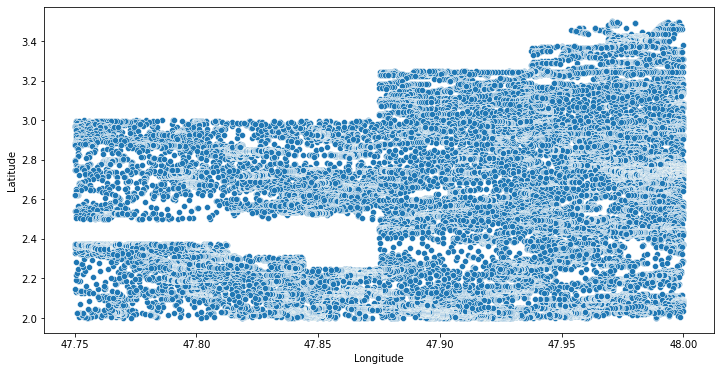

In [219]:
# Plotting the longitude and latitude of each point in the the files
plot_scatter(combined_df)

In [220]:
# Getting the longitudes and latitudes of every point for later use (meshgrid)
X = combined_df['Longitude']
Y = combined_df['Latitude']

In [221]:
# Removing the 'osm_id' and 'way' columns from the dataframe
combined_df = combined_df.drop(columns=['way', 'osm_id'])

### Fusion of positions 

In [222]:
import numpy as np



num_cells = 50

min_longitude = np.min(X)
max_longitude = np.max(X)

min_latitude = np.min(Y)
max_latitude = np.max(Y)

delta_longitude = (max_longitude - min_longitude)/num_cells
delta_latitude =  (max_latitude - min_latitude)/num_cells

x_values = np.linspace(min_longitude, max_longitude, num_cells)
y_values = np.linspace(min_latitude, max_latitude, num_cells)

Longitude, Latitude = np.meshgrid(x_values, y_values, indexing='xy')

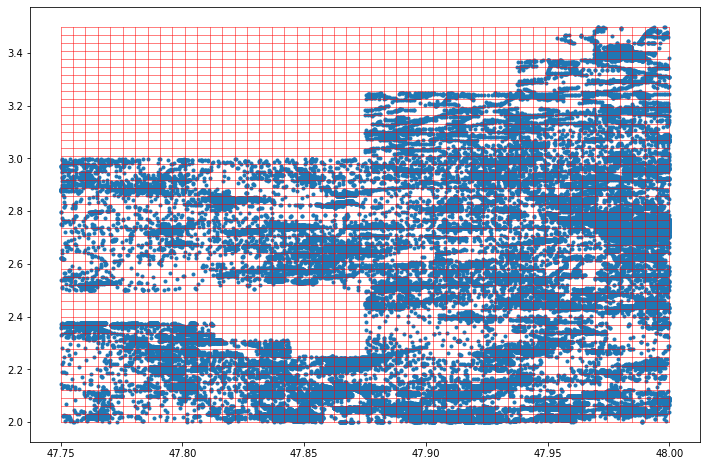

In [223]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, marker='.')
plt.plot(Longitude.T, Latitude.T, color='red', linestyle = '-', linewidth = 0.5)
plt.plot(Longitude, Latitude, color='red', linestyle = '-', linewidth = 0.5)
plt.show()

In [224]:
# Getting the regions from the positions
regions = {}

for position in combined_df.iterrows():
    longitude_ = position[1].Longitude
    latitude_ = position[1].Latitude
    # break

    i_, j_ = int(((longitude_ - min_longitude)// delta_longitude)), int(((latitude_ - min_latitude)// delta_latitude))
    if (i_, j_) in regions:
        regions[(i_, j_)].append(position)
    else:
        regions[(i_, j_)] = [position]

In [225]:
# print(regions.keys())


In [226]:
# Getting the largest, smallest area in terms of positions and the mean and std of the regions
sizes_of_regions = [len(values) for key, values in regions.items()]
print("Size of the largest area : ", np.max(sizes_of_regions))
print("Size of the smallest area : ", np.min(sizes_of_regions))
print("Mean of sizes : ", np.mean(sizes_of_regions))
print("Standard deviation of sizes : ", np.std(sizes_of_regions))

Size of the largest area :  2557
Size of the smallest area :  1
Mean of sizes :  56.48411829134721
Standard deviation of sizes :  146.50240651502475


In [227]:
# transforming the regions to dataframes
for key, value in regions.items():
    dataframes_list = [val[1].to_frame().T for val in value]
    result_df = pd.concat(dataframes_list, ignore_index=True)
    regions[key] = result_df

### Creation of the Vocabulary

In [228]:
# Creating a vocab of every attribut
variables = combined_df.columns.tolist()
vocabularies = []

for i in range (0, len(variables)-2):
    values = combined_df[variables[i]].unique()
    values = np.array(values)
    voc = {value: i for i, value in enumerate(values)}
    vocabularies.append(voc)

In [229]:
print(len(variables))

69


In [230]:
print(vocabularies[60]) #Variable entièrement nulle
print(variables[60])

{None: 0}
tunnel


In [231]:
# getting the barycenters of every region
barycenters = {}

for key, val in regions.items():
    longitude = np.array(val['Longitude'])
    latitude = np.array(val['Latitude'])
    
    mean_longitude = np.mean(longitude)
    mean_latitude = np.mean(latitude)

    barycenters[key] = (mean_longitude, mean_latitude)

### Vectorization

In [232]:
# Getting the attributs (using a counter) of every region in a list X
X = []
dim = len(variables)

for key, value in regions.items():
    x = np.zeros(dim)
    for i, variable in enumerate(variables):
        x[i] = value[variable].count()
    X.append(x)
    
X = np.array(X)

In [233]:
# Removing the longitude and latitude attributs
X = X[:, :-2]
print(X.shape)
print(X[0])

(1826, 67)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  2.  0.  0.  0. 15.  0.  0. 15.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.]


In [234]:
# Mapping of the regions key (tuple) to an id
key_ids = {key:i for i, key in enumerate(regions)}
id_to_key = {val:key for key, val in key_ids.items()} 

In [235]:
# print(key_ids)

##### PCA transformation

In [236]:
from sklearn.decomposition import PCA

# Applying PCA to get just 3 features
pca = PCA(n_components=3)

X_train = pca.fit_transform(X)

vectors = {}

i = 0
for key, value in key_ids.items():
    vectors[value] = X_train[i]
    i += 1

In [237]:
df_train = pd.DataFrame(vectors).T
df_train

,0,1,2
0,-36.217652,0.486891,15.539347
1,-37.018022,0.211842,-0.182966
2,-36.617785,0.254682,5.643222
3,-37.018241,0.116440,-5.757857
4,-37.047250,0.189920,-1.592410
...,...,...,...
1821,-12.327808,-2.206917,-4.611887
1822,-36.837948,0.247449,-5.706581
1823,-32.802814,-0.174167,-4.378135
1824,-33.785729,-0.055577,-4.350750


In [238]:
# Using KMeans
kmeans = KMeans(n_clusters=1000, random_state=42, n_init='auto').fit(df_train)

# Getting the regions that are in each cluster
kmeans_labels = kmeans.labels_
cluster_data = {}
for i in range(kmeans.n_clusters):
    cluster_data[i] = [j for j, label in enumerate(kmeans_labels) if label==i]


In [239]:
for cluster, data_entries in cluster_data.items():
    print(f"Cluster {cluster} contains data entries: {data_entries}")

Cluster 0 contains data entries: [95, 670, 682, 683, 872, 1357, 1650]
Cluster 1 contains data entries: [380]
Cluster 2 contains data entries: [1549]
Cluster 3 contains data entries: [1224]
Cluster 4 contains data entries: [1630]
Cluster 5 contains data entries: [1480]
Cluster 6 contains data entries: [1090]
Cluster 7 contains data entries: [1782]
Cluster 8 contains data entries: [728]
Cluster 9 contains data entries: [22]
Cluster 10 contains data entries: [934]
Cluster 11 contains data entries: [1626]
Cluster 12 contains data entries: [1199]
Cluster 13 contains data entries: [378]
Cluster 14 contains data entries: [1214]
Cluster 15 contains data entries: [1781]
Cluster 16 contains data entries: [23]
Cluster 17 contains data entries: [1161]
Cluster 18 contains data entries: [1554]
Cluster 19 contains data entries: [1468]
Cluster 20 contains data entries: [1551]
Cluster 21 contains data entries: [258, 961]
Cluster 22 contains data entries: [1483]
Cluster 23 contains data entries: [758]
C

In [249]:
# Getting a testing element from the dataframe
sample = combined_df.iloc[100000]
sample_x = []
for variable in variables[:-2]:
    sample_x.append(sample[variable])
sample_x = (np.array(sample_x) != None)*1

In [250]:
print(sample_x.reshape(1, -1))


[[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [251]:
# Aplying pca to the test element
X_test = pca.transform(sample_x.reshape(1, -1))

In [252]:
# Predicting the correct cluster for the x_test 
y_pred = kmeans.predict(X_test)

In [253]:
print(y_pred)
# Getting the regions for that cluster
predicted_cluster = cluster_data[y_pred[0]]
print(predicted_cluster)

[631]
[242, 547, 562, 566, 652, 653, 659, 672, 791, 1061, 1244, 1326, 1709]


In [254]:
# Getting the barycenters for the regions that are in the predicted cluster
cluster_barycenters = []

for region in predicted_cluster:
    key = id_to_key[region]
    cluster_barycenters.append(barycenters[key])

In [255]:
print(cluster_barycenters)

[(47.880671449999994, 3.0018079), (47.841982900000005, 2.8925897333333332), (47.82183335, 2.9973737), (47.812661250000005, 2.992843), (47.7702641, 2.8176733499999997), (47.777288666666664, 2.8235970666666668), (47.7501004, 2.7963575), (47.7873082, 2.7962309999999997), (47.80751909999999, 2.74092585), (47.956673980000005, 2.6853573400000004), (47.913174749999996, 2.3723253499999997), (47.9756135, 2.35697255), (47.7594585, 2.10970805)]


In [256]:
import folium

# Drawing the barycenter position of the regions in the cluster and the ground truth (red)
m = folium.Map(zoom_start=12)

for pos in cluster_barycenters:
    folium.Marker(
        location=[pos[0], pos[1]],
        tooltip="Click me!",
        popup="Barycenter " + str(i),
        icon=folium.Icon(icon="green"),
    ).add_to(m)

folium.Marker(
    location=[combined_df.iloc[100000][-1], combined_df.iloc[100000][-2]],
    tooltip="Click me!",
    popup="Timberline Lodge",
    icon=folium.Icon(color="red"),
).add_to(m)

In [257]:
m